### Prerequisites

[Anaconda](https://www.anaconda.com/) installed

[Python 3.9](https://www.python.org/downloads/) installed

Note that you will be creating a Python environment with 3.9 in the Setup the Python Environment step

A Snowflake account with [Anaconda Packages enabled by ORGADMIN](https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-packages.html#using-third-party-packages-from-anaconda). If you do not have a Snowflake account, you can register for a free trial account.

A Snowflake account login with a role that has the ability to create database, schema, tables, stages, user-defined functions, and stored procedures. 

If not, you will need to register for a [free trial](https://signup.snowflake.com/) or use a different role.

### Python Environment
To create our python environment we run the following in our terminal

conda create --name ai-demo --override-channels -c https://repo.anaconda.com/pkgs/snowflake python=3.9 
conda activate ai-demo
conda install -c https://repo.anaconda.com/pkgs/snowflake snowflake-connector-python snowflake-snowpark-python snowflake snowflake-ml-python xgboost os json cachetools joblib

### What is Snowpark?
Snowpark is the set of libraries and runtimes that securely enable developers to deploy and process Python code in Snowflake.

Familiar Client Side Libraries - Snowpark brings deeply integrated, DataFrame-style programming and OSS compatible APIs to the languages data practitioners like to use. It also includes a set of Snowpark ML APIs for more efficient ML modeling (public preview) and ML operations (private preview).

Flexible Runtime Constructs - Snowpark provides flexible runtime constructs that allow users to bring in and run custom logic. Developers can seamlessly build data pipelines, ML models, and data applications with User-Defined Functions and Stored Procedures.

Learn more about [Snowpark](http://www.snowflake.com/snowpark).

### What is Snowpark ML?
Snowpark ML is a new library for faster and more intuitive end-to-end ML development in Snowflake. Snowpark ML has 2 APIs: Snowpark ML Modeling (public preview) for model development and Snowpark ML operations (private preview) for model deployment.

This quickstart will focus on the Snowpark ML Modeling API, which scales out feature engineering and simplifies ML training execution.

**Preprocessing**: Improve performance and scalability with distributed, multi-node execution for common feature engineering functions

**Model Training**: Execute training for popular scikit-learn and xgboost models without manual creation of Stored Procedures or UDFs

[Snowpark ML](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling)

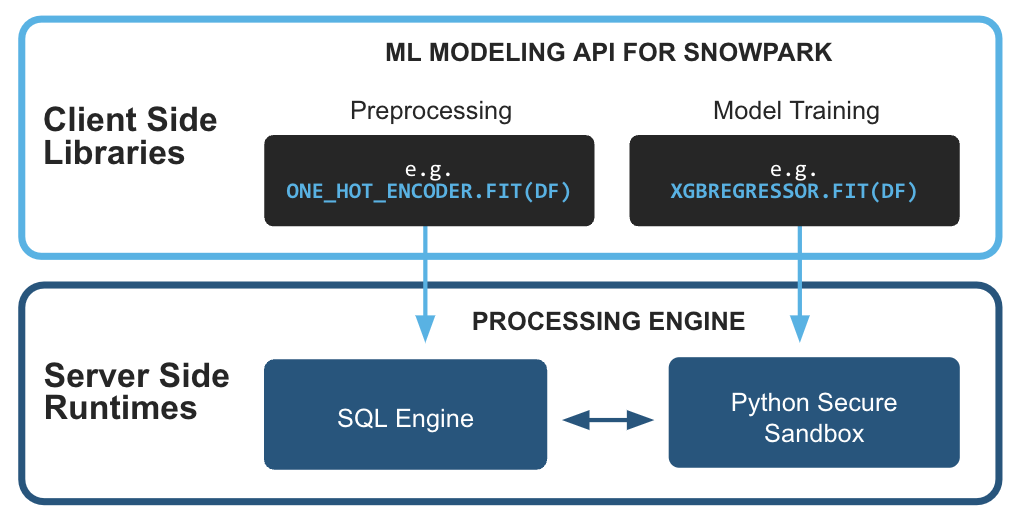

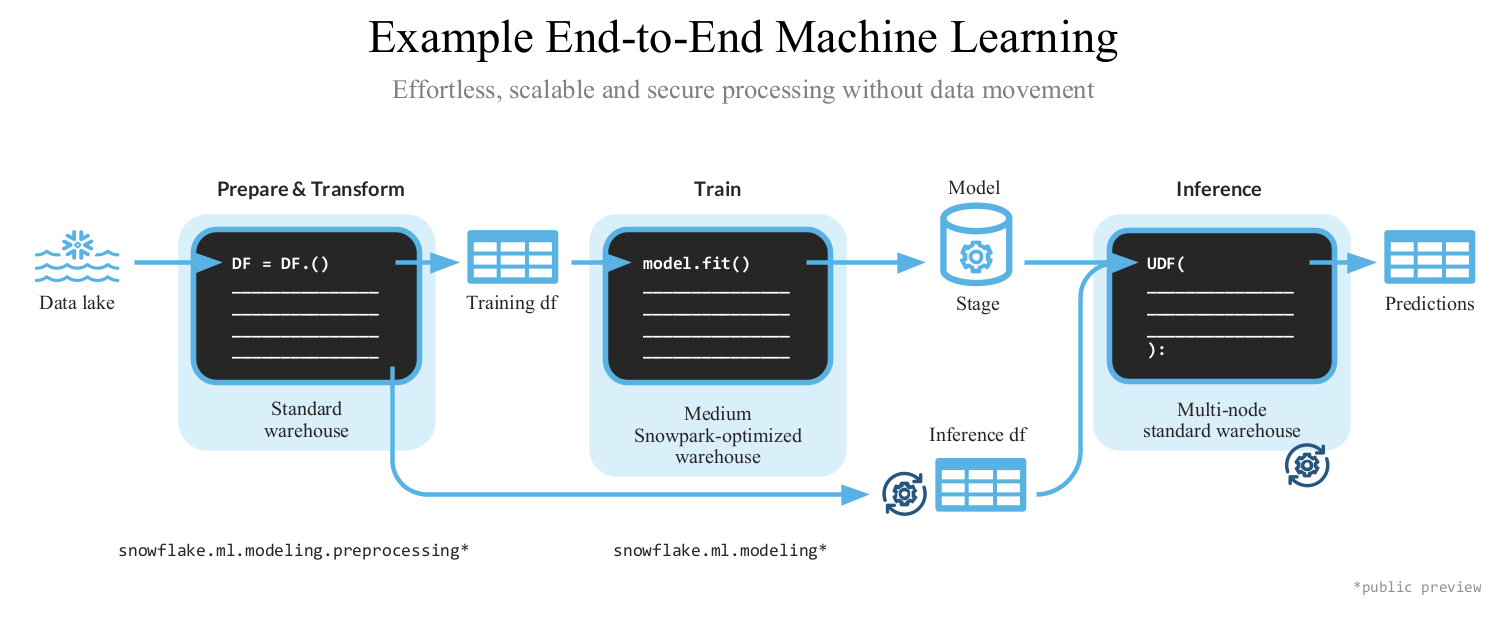

### Goal: Reproduce Trillion Dollar Words

Our goal in this project is to reproduce the work in a recent academic paper called *Trillion Dollar Words*, the paper is available [here](https://aclanthology.org/2023.acl-long.368/). The paper labels FOMC meetings and press conference as hawkish, dovish or neutral (and offers evidence that a domain specific model outperforms a general purpose model like GPT) and then incorporates that sentiment into a workflow to model inflation, treasury rates and market movements. We will reproduce the sentiment extraction and then incorporate the sentiment features into a model to predict inflation using the xgboost algorithm. We are working with about 60 observations here by way of example - to generate a robust model we would need more data.

In [1]:
### Load Libraries
# Snowpark
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import udf, col, lag, lit, trunc, to_date, replace, last_day, mean, median
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
import snowflake.connector

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error


# data sci libraries
import pandas as pd
import os
import json
import numpy as np
import joblib
import cachetools


# warning suppresion
import warnings; warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Enter Creds, Connect to Snowflake and Create Session

# Read credentials
with open('creds.json') as f:
    connection_parameters = json.load(f)
# Connect to a snowflake session
session = Session.builder.configs(connection_parameters).create()

In [3]:
# check or confirm current session settings? 
session.get_current_database()
session.get_current_schema()
session.get_current_warehouse()

# What version of snowpark are we running?
snowpark_version = VERSION

print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Snowpark for Python version : 1.8.0


### Press Conference Data 

The notebook we just ran in the Snowflake cloud saved our scored FOMC press conferences to our database.
The next section walks through how to take a csv from github and save it to Snowflake in case you wish to reproduce this work but skip that step where we use container services. That services requires GPUs and is only available commercially at the moment.

### Upload data to Snowflake

If you're running this document from github, you will need to load data to your Snowflake account. These two csv's are available on the github repository here: 

https://github.com/sfc-gh-jregenstein/aifutureoffinance

I downloaded them to my local FOMC-ROBERTA folder and here's how to access them and load to Snowflake. 

In [ ]:
pc_data = pd.read_csv("FOMC-ROBERTA/pc_data_for_csv.csv")

pc_data.head(5)

pc_data =pc_data[['DATE', 'SENTENCE', 'HAWKISH']]

session.write_pandas(pc_data, "PRESS_CONFERENCE_SCORED_UPPER_DATA", overwrite='True')

### Transform and Create Features

From here, we're going to do some wrangling on this data that is different from how the paper treats it - which is the power of being able to pull models off of Hugging Face, deploy them locally and then use the resulting data in our pipelines. We get to be creative. 

We'll calculate the monthly change in hawkishness for Fed sentiment, so that we can eventually pass that change as a feature to our model for predicting changes in inflation. The wrangling below happens in the cloud, not on my desktop. 

In [3]:
 # PC Scored Data Wrangling
date_win = snp.Window.order_by('DATE')

fed_percent_sent =   (
    session.table("PRESS_CONFERENCE_SCORED_UPPER_DATA")  
    .groupBy(['DATE'])
    .agg(
    median('HAWKISH').alias('MEDIAN_SENTIMENT'),
    mean('HAWKISH').alias('MEAN_SENTIMENT'),
    ) 
    .sort('DATE') 
   .with_column('LAG_FOMC_MEAN_SENTIMENT', lag('MEAN_SENTIMENT', offset=1) \
    .over(date_win)
   )
   .with_column('FED_CHANGE', (col('MEAN_SENTIMENT') - col('LAG_FOMC_MEAN_SENTIMENT'))/col('LAG_FOMC_MEAN_SENTIMENT'))  
   .with_column('FRED_DATE', last_day('DATE'))
   .select('FRED_DATE', 'FED_CHANGE')
)

fed_percent_sent.show(5)

--------------------------------------
|"FRED_DATE"  |"FED_CHANGE"          |
--------------------------------------
|2011-04-30   |NULL                  |
|2011-06-30   |-0.40139179661506463  |
|2011-11-30   |-0.1660254725874544   |
|2012-01-31   |-0.41036275029058394  |
|2012-04-30   |0.5945497548217885    |
--------------------------------------



### Inflation Data

We're going to explore whether that change in Fed sentiment helps us model changes in inflation. We have only about 60 observations here but our goal is to explore this process and how to create new features and input them into a model. First let's load up our inflation data. This is CPI data, readily available on FRED or in the Snowflake marketplace via Cybersyn. 

In [4]:
cpi_data = session.table("CPI_DATA")


Next we join our Fed sentiment data with our Inflation data, aligning the change in Fed sentiment with the change in inflation. In practice we would want to explore many different lags.

In [5]:
date_win = snp.Window.order_by('DATE')

fed_percent_sent.show(5)

cpi_fed = (
    cpi_data 
    .with_column('LAG_CPI_12', lag('VALUE', offset=12) \
    .over(date_win)
   )
   .with_column('CPI_CHANGE', (col('VALUE') - col('LAG_CPI_12'))/col('LAG_CPI_12'))  
   .join(fed_percent_sent, cpi_data.col('DATE') == fed_percent_sent.col('FRED_DATE'))
   .select('FED_CHANGE', 'CPI_CHANGE')
   .dropna()

)

cpi_fed.show(5)

--------------------------------------
|"FRED_DATE"  |"FED_CHANGE"          |
--------------------------------------
|2011-04-30   |NULL                  |
|2011-06-30   |-0.40139179661506463  |
|2011-11-30   |-0.1660254725874544   |
|2012-01-31   |-0.41036275029058394  |
|2012-04-30   |0.5945497548217885    |
--------------------------------------

-----------------------------------------------
|"FED_CHANGE"          |"CPI_CHANGE"          |
-----------------------------------------------
|-0.40139179661506463  |0.03502318150636052   |
|-0.1660254725874544   |0.03451432214581724   |
|-0.41036275029058394  |0.030087663379855058  |
|0.5945497548217885    |0.02273163374134856   |
|-0.5674481441919873   |0.016538704482976386  |
-----------------------------------------------



### Feature Exploration

Next we run a light feature exploration with the built in correlation function. 

In [7]:
# Correlation

corr_cpi_fed_df = correlation(df=cpi_fed)
corr_cpi_fed_df # This is a Pandas DataFrame

,FED_CHANGE,CPI_CHANGE
FED_CHANGE,1.000000,0.032984
CPI_CHANGE,0.032984,1.000000


### XGBOOST

Now let's move on to modeling this data, using our change in fed sentiment to attempt to predict changes in inflation.

The model.fit() function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a Snowpark Optimized Warehouse if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.

The model.predict() function actualls creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.

In the code chunk below, we use a snowpark optimized warehouse, then split our data into train and test, specify and fit our model. Then predict our test set so we can run a mape evaluation.

In [6]:
session.use_warehouse('snowpark_opt_wh')

# Split the data into train and test sets
fomc_train_df, fomc_test_df = cpi_fed.random_split(weights=[0.7, 0.3], seed=0)

fomc_train_df.show(5)

# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=['FED_CHANGE'],
    label_cols=['CPI_CHANGE'],
    output_cols=['PREDICTED_CPI_CHANGE']
)

# Train
regressor.fit(fomc_train_df)

# Predict
result = regressor.predict(fomc_test_df)

result.to_pandas()


-----------------------------------------------
|"FED_CHANGE"          |"CPI_CHANGE"          |
-----------------------------------------------
|-0.40139179661506463  |0.03502318150636052   |
|-0.1660254725874544   |0.03451432214581724   |
|-0.41036275029058394  |0.030087663379855058  |
|0.5945497548217885    |0.02273163374134856   |
|2.0767445787677996    |0.019497168982819623  |
-----------------------------------------------



,FED_CHANGE,CPI_CHANGE,PREDICTED_CPI_CHANGE
0,-0.333394,0.018531,0.082663
1,0.182161,0.017935,0.085136
2,-0.044036,0.017692,0.022679
3,0.009875,0.007160,0.024956
4,0.270682,0.013715,0.087746
5,0.277883,0.013220,0.087746
6,0.050257,0.082149,0.074253
7,-0.567448,0.016539,0.016896
8,0.527792,0.015187,0.022914
9,-0.079385,0.015128,0.050252


Let's evaluate our model using MAPE. This is to help learn about these functions - this data set is too small.

In [9]:
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="CPI_CHANGE", 
                                        y_pred_col_names="PREDICTED_CPI_CHANGE")

result.select("CPI_CHANGE", "PREDICTED_CPI_CHANGE").show()
print(f"Mean absolute percentage error: {mape}")

--------------------------------------------------
|"CPI_CHANGE"           |"PREDICTED_CPI_CHANGE"  |
--------------------------------------------------
|0.016538704482976386   |0.016896042972803116    |
|0.01518747241124626    |0.02291369251906872     |
|0.015128383667573405   |0.050251565873622894    |
|0.01684050971123211    |0.019942857325077057    |
|0.006531213919623104   |0.002668587956577539    |
|0.0017957180975505568  |0.015436392277479172    |
|0.008916160965521974   |0.0226790364831686      |
|0.020507989115119824   |0.08266300708055496     |
|0.024411962365591327   |0.015436392277479172    |
|0.021805652303711873   |0.050251565873622894    |
--------------------------------------------------

Mean absolute percentage error: 2.1956405827328855


We can run a grid search to hunt for optimal hyperparameters. We are releasing a new version of this soon for auto parallelization.

In [17]:
### Grid Search

LABEL_COL = ['CPI_CHANGE']


grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=['FED_CHANGE'],
    label_cols=LABEL_COL,
    output_cols=['PREDICTED_CPI_CHANGE']
)

# Train
grid_search.fit(fomc_train_df)


# Predict
result = grid_search.predict(fomc_test_df)

# Analyze results
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="CPI_CHANGE", 
                                        y_pred_col_names="PREDICTED_CPI_CHANGE")

result.select("CPI_CHANGE", "PREDICTED_CPI_CHANGE").show()
print(f"Mean absolute percentage error: {mape}")


# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []

for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})



# Let's save our optimal model first and its metadata
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

optimal_mape = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                                 (gs_results_df['learning_rate']==optimal_learning_rate), 'mape']


--------------------------------------------------
|"CPI_CHANGE"           |"PREDICTED_CPI_CHANGE"  |
--------------------------------------------------
|0.016538704482976386   |0.01718643680214882     |
|0.01518747241124626    |0.02282901667058468     |
|0.015128383667573405   |0.04863398522138595     |
|0.01684050971123211    |0.019962146878242493    |
|0.006531213919623104   |0.0031781932339072227   |
|0.0017957180975505568  |0.015560289844870567    |
|0.008916160965521974   |0.021562397480010983    |
|0.020507989115119824   |0.08134239166975021     |
|0.024411962365591327   |0.015560289844870567    |
|0.021805652303711873   |0.04863398522138595     |
--------------------------------------------------

Mean absolute percentage error: 2.1463284768524


Finally, we register our model and save it, so we can track and upate it, and call it for inference on new data sets.

In [24]:
### Model Register

# Get sample input data to pass into the registry logging function
X = fomc_train_df.select('FED_CHANGE').limit(10)


db = identifier._get_unescaped_name(session.get_current_database())
schema = identifier._get_unescaped_name(session.get_current_schema())

# Define model name and version
model_name = "cpi_fed_model"
model_version = 3

# Create a registry and log the model
registry = model_registry.ModelRegistry(session=session, database_name=db, schema_name=schema, create_if_not_exists=True)

registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=optimal_model,
    sample_input_data=X,
    options={"embed_local_ml_library": True, # This option is enabled to pull latest dev code changes.
             "relax": True} # relax dependencies
)

# Add evaluation metric
registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)


# Let's confirm it was added
registry.list_models().to_pandas()


# Pick a deployment name and deploy
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name, 
                target_method="predict", 
                permanent=True, 
                options={"relax_version": True})


# Let's confirm it was added
registry.list_deployments(model_name, model_version).to_pandas()




,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE
0,cpi_fed_model,3,cpi_fed_model3_UDF,2023-11-06 17:13:23.180000-08:00,predict,warehouse,"{\n ""inputs"": [\n {\n ""name"": ""FED_CH...","{\n ""permanent_udf_stage_location"": ""@FOMC_RO...",@FOMC_ROBERTA.FOMC_SCHEMA._SYSTEM_REGISTRY_DEP...,"""ACCOUNTADMIN"""
